In [44]:
from Crypto.Hash import keccak
import requests  
import json
import pandas as pd 
from web3 import Web3
from web3.middleware import geth_poa_middleware
import pandas as pd 
from datetime import datetime

url = 'https://api.snowtrace.io/api'
api_key = '***'                                             # Add your API key here (https://snowtrace.io/myapikey)
contract_adress = '0x5857019c749147EEE22b1Fe63500F237F3c1B692' # This is the vePTP adress

w3 = Web3(Web3.HTTPProvider('https://api.avax.network/ext/bc/C/rpc'))
w3.middleware_onion.inject(geth_poa_middleware, layer=0)

current_block_number = int(w3.eth.get_block('latest')['number']) # current block
ptp_denominator = 1000000000000000000                            # ptp denominator, to convert to decimal PTP amount        

In [4]:
# this function will get all transactions from a specific block number
def getAllTransactions(contract_adress, start_block=0):
    end_reached = False
    transactions = []
    indexed_hashes = {}
    block_number = start_block
    
    while end_reached == False:
        r = requests.get(url, params={  
            'module': 'account',  
            'action': 'txList',  
            'address': contract_adress,  
            'apikey':  api_key, 
            'startblock': block_number,
            'endblock': current_block_number,
            'sort': 'asc'
        })
        
        new_transaction_found = False
        results = json.loads(r.text)["result"]
        for result in results:
            if not result["hash"] in indexed_hashes:
                transactions.append(result)
                indexed_hashes[result["hash"]] = True
                new_transaction_found = True
        
        new_block_number = int(results[-1]["blockNumber"])
        last_timestamp = datetime.utcfromtimestamp(int(results[-1]["timeStamp"])).strftime('%Y-%m-%d %H:%M:%S')
        print(f"Got to block: {block_number}. Transactions #{len(transactions)}. Results: {len(results)}. Last timestamp: {last_timestamp}. ")
        
        if block_number == new_block_number:
            end_reached = True
        else:
            block_number = new_block_number
    
    return transactions

In [5]:
allTransactions = getAllTransactions(contract_adress)
len(allTransactions)

Got to block: 0. Transactions #10000. Results: 10000. Last timestamp: 2022-01-15 02:37:47. 
Got to block: 9584202. Transactions #19997. Results: 10000. Last timestamp: 2022-01-15 16:17:35. 
Got to block: 9609092. Transactions #29996. Results: 10000. Last timestamp: 2022-01-16 05:42:59. 
Got to block: 9634143. Transactions #39995. Results: 10000. Last timestamp: 2022-01-16 15:52:15. 
Got to block: 9652679. Transactions #49994. Results: 10000. Last timestamp: 2022-01-17 05:44:58. 
Got to block: 9678082. Transactions #59993. Results: 10000. Last timestamp: 2022-01-17 18:10:35. 
Got to block: 9700434. Transactions #69992. Results: 10000. Last timestamp: 2022-01-18 12:19:34. 
Got to block: 9732964. Transactions #79991. Results: 10000. Last timestamp: 2022-01-19 06:28:23. 
Got to block: 9765674. Transactions #89990. Results: 10000. Last timestamp: 2022-01-20 00:28:29. 
Got to block: 9798218. Transactions #99989. Results: 10000. Last timestamp: 2022-01-20 21:17:29. 
Got to block: 9835100. Tra

200284

In [6]:
deposits = [result for result in allTransactions if result['input'].startswith('0xb6b55f25')]

In [32]:
struct_deposits = [{'timestamp': datetime.utcfromtimestamp(int(result["timeStamp"])).strftime('%Y-%m-%d'),
                    'from': result["from"],
                    'value': int(result['input'][-20:], 16) / ptp_denominator } 
                   for result in deposits if result['isError'] == '0']

In [35]:
df_deposits = pd.json_normalize(struct_deposits)
df_deposits[["timestamp", "from", "value"]].tail()

,timestamp,from,value
55732,2022-02-15,0xeea30dfeab54a05434967f4540cddcd61dca2d21,11.520649
55733,2022-02-15,0x629fad392bcf377efc8a6ca3549e97a399e419da,79.112124
55734,2022-02-15,0x81518347254d16d86d2da9b6184c80c03d3e0020,16.050271
55735,2022-02-15,0x8549361cd2c83e53fca7249fd734eb4b8821f610,118200.401160
55736,2022-02-15,0x1169b6d5703256e11c769188366ca5f2dc2a701d,12.026659


In [36]:
withdrawals = [result for result in allTransactions if result['input'].startswith('0x2e1a7d4d')]

In [37]:
struct_withdrawals = [{'timestamp': datetime.utcfromtimestamp(int(result["timeStamp"])).strftime('%Y-%m-%d'),
                       'from': result["from"],
                       'isError': result['isError'],
                       'value': int(result['input'][-20:], 16) / ptp_denominator } 
                     for result in withdrawals if result['isError'] == '0']

In [38]:
df_withdrawals = pd.json_normalize(struct_withdrawals)
df_withdrawals[["timestamp", "from", "value"]].tail()

,timestamp,from,value
6961,2022-02-15,0x038543cd93c129b820d6151f5c699602756ca1b9,12.721665
6962,2022-02-15,0x39de6abe3e2918e89da31b23ac1b8c6ad01bf21e,13.700000
6963,2022-02-15,0x5edb42f398b3e9ccc34f7ec3461cace7a8f2640b,12.803416
6964,2022-02-15,0x5210706caf8428f079e3a9a75037566eb7bc4abb,8.973074
6965,2022-02-15,0x3490bdb469454a6f16c2c6bde8b6bb0dde36532f,10.640649


In [39]:
df_daily_deposits=df_deposits.groupby('timestamp').agg(['sum']).reset_index()
df_daily_deposits.tail()

,timestamp,from,value
,,sum,sum
28,2022-02-11,0x743e732944fe0e40bd50731cc9cd4e0d9568cbbe0x92...,129557.274917
29,2022-02-12,0x40d3aaf33366576a7fc3987b047a4d2c8d77ea4f0x50...,144345.725069
30,2022-02-13,0xdf90663d8cdfbc463efa6c8ef85a05671c8b2e730xa0...,95599.562126
31,2022-02-14,0xc25db8633d8ca617df39db3f0fb515e0aeead14b0x67...,123875.631832
32,2022-02-15,0xc19f526a27dda0b357f8a748b8691fbfbcad561b0x34...,241577.554305


<AxesSubplot:xlabel='timestamp'>

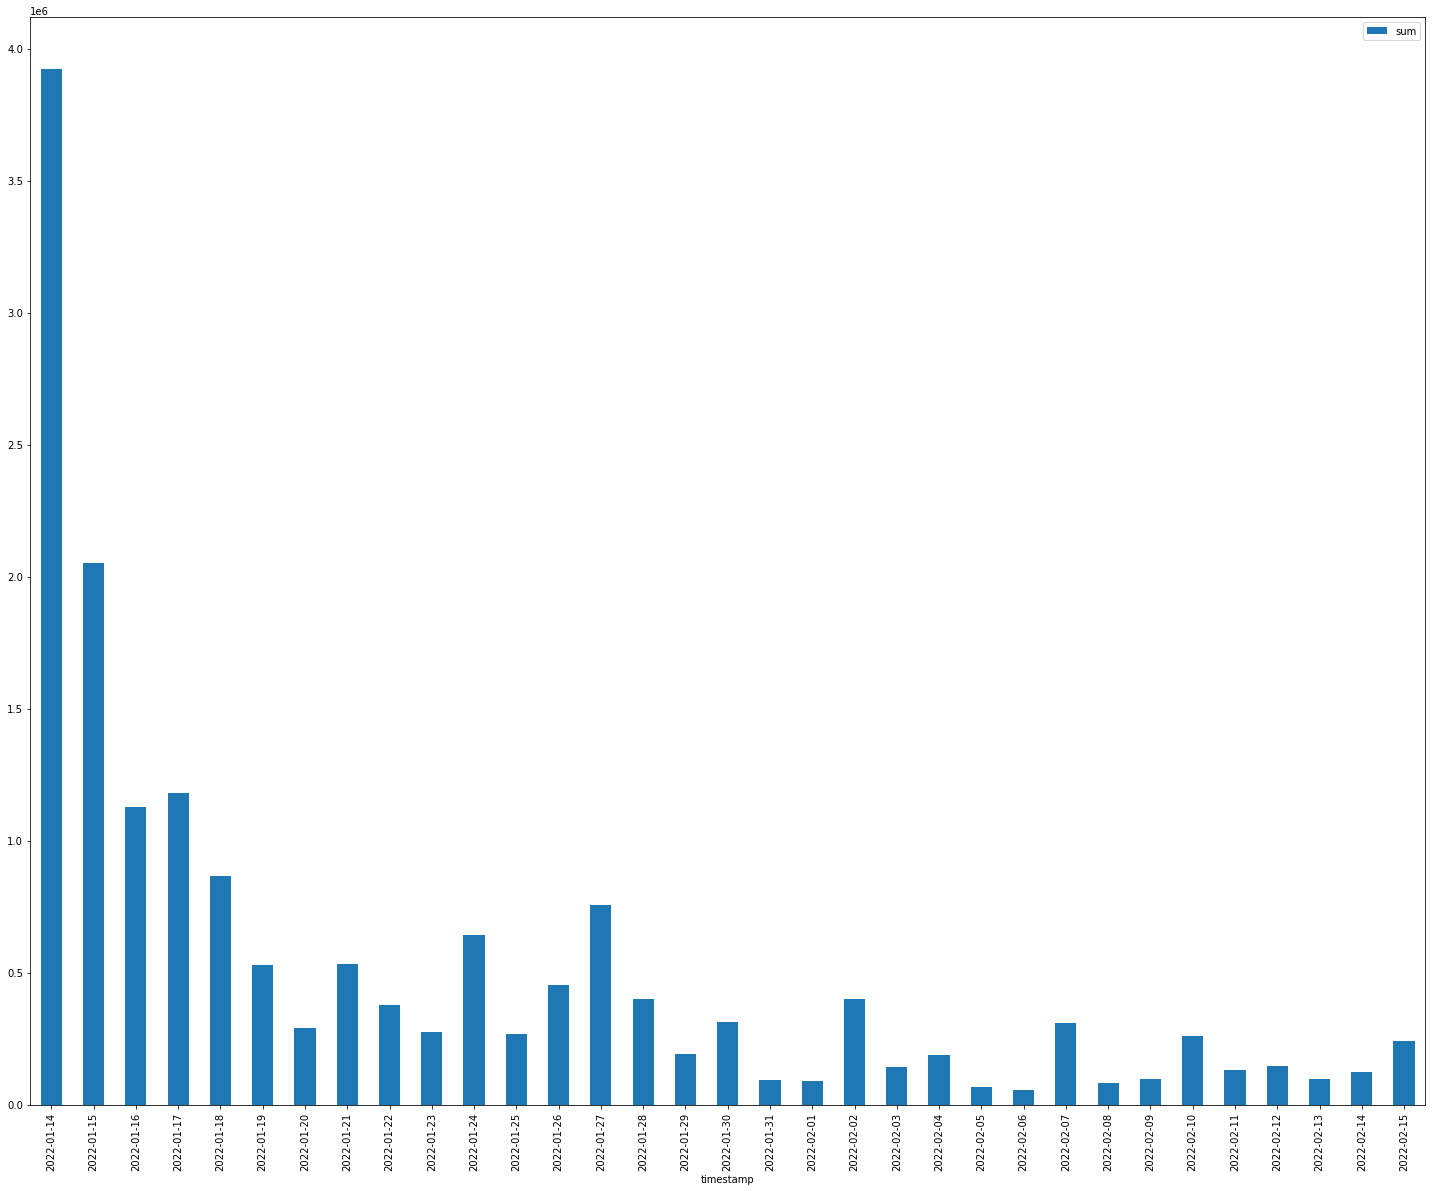

In [40]:
df_daily_deposits.plot(x='timestamp', y='value',kind="bar", figsize=(25,20))

In [41]:
df_daily_withdraw = df_withdrawals.groupby('timestamp').agg(['sum']).reset_index()
df_daily_withdraw.tail()

,timestamp,from,isError,value
,,sum,sum,sum
28,2022-02-11,0xa8b0ef328b43945f24ed99718d151b46aa771f470x14...,0000000000000000000000000000000000000000000000...,67505.056489
29,2022-02-12,0x468fd68b81475ac46d00f491bfa52ef8aaa17e970x2d...,0000000000000000000000000000000000000000000000000,48686.905935
30,2022-02-13,0x16e23c85be01cdf56c3b9f0fbc9308a285e5c9a80x07...,000000000000000000000000000000000,13482.687859
31,2022-02-14,0x3853cfc54c63d2f2ba61c3190dffb60d85cd56940x51...,0000000000000000000000000000000000000000000000...,29809.627744
32,2022-02-15,0x7ea4b8e821e41b561d97d5adc4df5fc75eff7fee0xa9...,0000000000000000000000000000000000000,4891.564536


<AxesSubplot:xlabel='timestamp'>

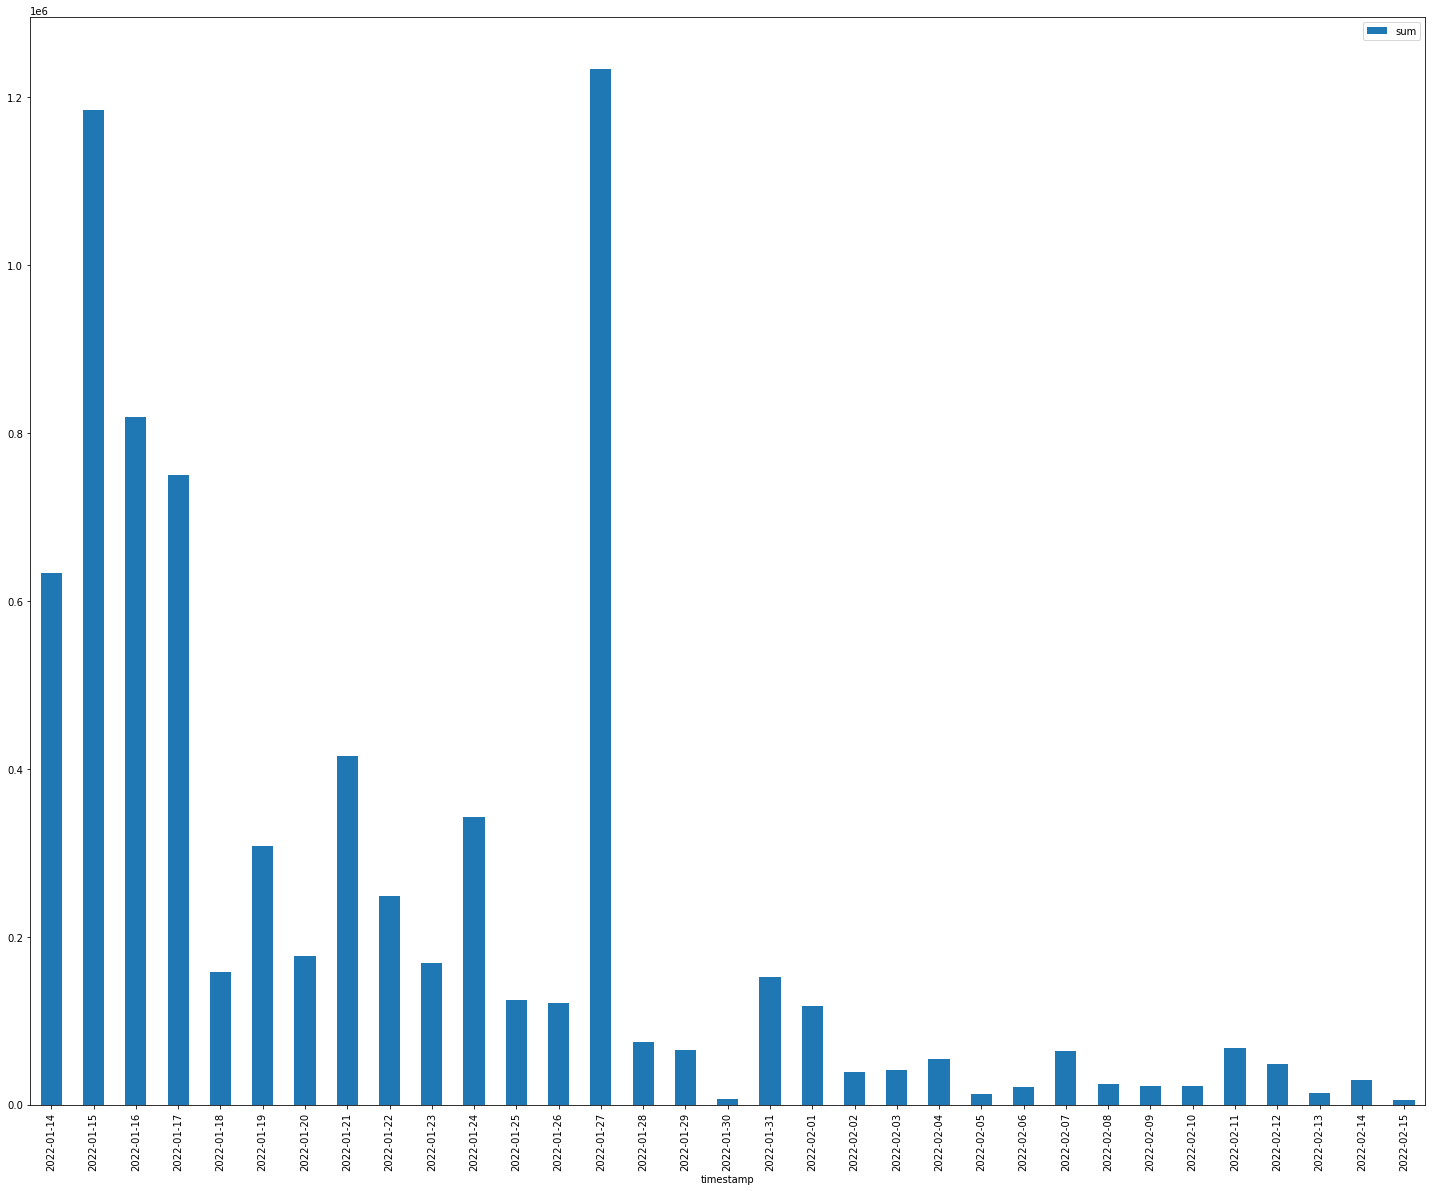

In [42]:
df_daily_withdraw.plot(x='timestamp', y='value',kind="bar", figsize=(25,20))

<AxesSubplot:>

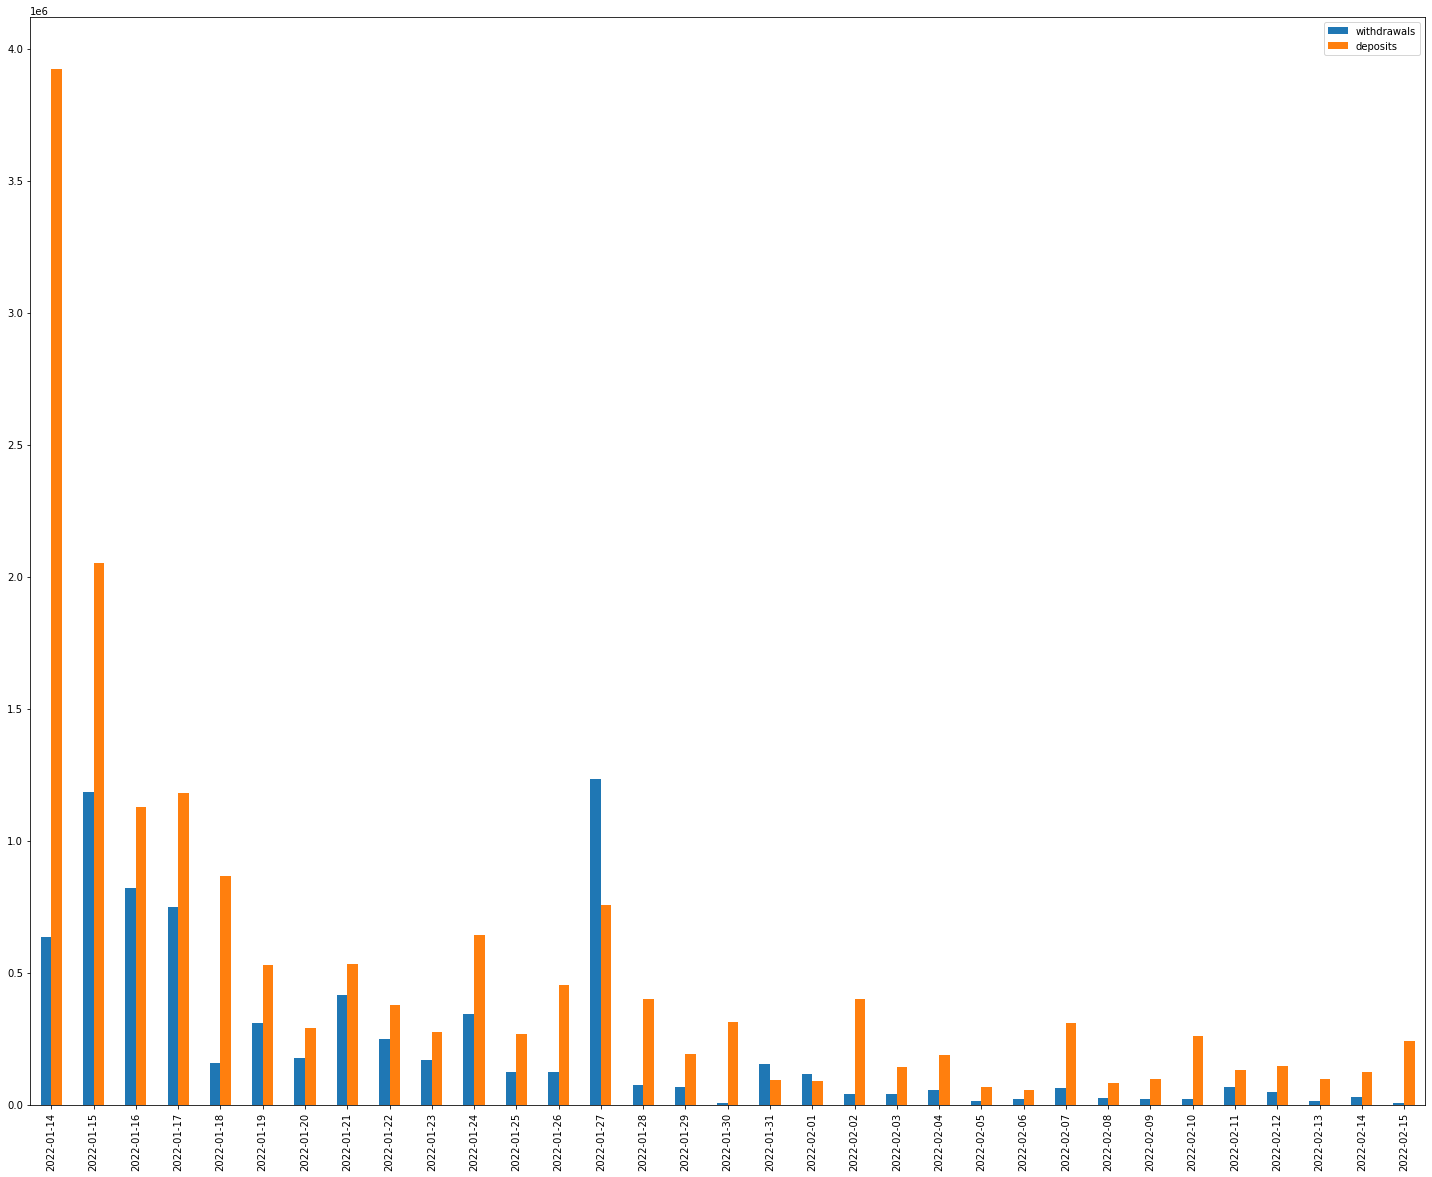

In [43]:
plotdata = pd.DataFrame({
    "withdrawals": df_withdrawals.groupby('timestamp').agg(['sum']).reset_index()['value'].values.flatten(),
    "deposits": df_deposits.groupby('timestamp').agg(['sum']).reset_index()['value'].values.flatten(),
    }, 
    index=df_deposits.groupby('timestamp').agg(['sum']).reset_index()['timestamp'].values.flatten()
)
plotdata.plot(kind="bar", figsize=(25,20))